In [1]:
wes_bed = "/home/jovyan/work/00.database/bed_hg38_hg19/170907_HG38_CCDS1X_REZ_primary_targets.bed"
dbsnp = "/home/jovyan/work/00.database/14.dbSNP/All_20180418.vcf.gz"
dbsnp_in_wes = "/home/jovyan/work/00.database/14.dbSNP/All_20180418_in_WES.vcf.gz"

case_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0009689008_CA/results/08.SvInDelSnvCalling/COAD_0009689008_CA.single_variant.snpeff.vcf"
ctrl_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0009689008_N/results/08.SvInDelSnvCalling/COAD_0009689008_N.single_variant.snpeff.vcf"

In [2]:
import gzip
import time
from collections import defaultdict

def build_bed_regions(bed_file):
    bed_regions = defaultdict(lambda: defaultdict(list))
    with open(bed_file, "r") as file:
        for line in file:
            chrom, start, end, _ = line.split()
            start, end = int(start), int(end)
            bin_index = start // 10000
            bed_regions[chrom][bin_index].append((start, end))
    return bed_regions

def extract_variants_in_bed(vcf_file, bed_regions, output_file):
    with gzip.open(vcf_file, "rt") as vcf_file, gzip.open(output_file, "wt") as out_file:
        for line in vcf_file:
            if line.startswith("#"):
                out_file.write(line)  # 将注释行写入输出文件
                continue

            fields = line.split()
            chrom, pos = "chr"+fields[0], int(fields[1])
            bin_index = pos // 10000

            # 检查该位点是否真正位于bin内的任何bed区域
            for start, end in bed_regions[chrom][bin_index]:
                if start <= pos < end:
                    out_file.write(line)
                    break

def main(wes_bed, dbsnp, dbsnp_in_wes):
    start_time = time.time()  # 记录开始时间

    # 构建bed文件区域集合
    bed_regions = build_bed_regions(wes_bed)

    # 遍历VCF文件,判断每个变异位点是否在bed区域内
    extract_variants_in_bed(dbsnp, bed_regions, dbsnp_in_wes)

    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time
    print(f"Script execution time: {elapsed_time:.2f} seconds")

if __name__ == "__main__":
    print("starting")
    #main(wes_bed, dbsnp, dbsnp_in_wes)

starting


Number of positions with same REF/ALT: 10241968
Ratio of positions with same REF/ALT: 0.9985


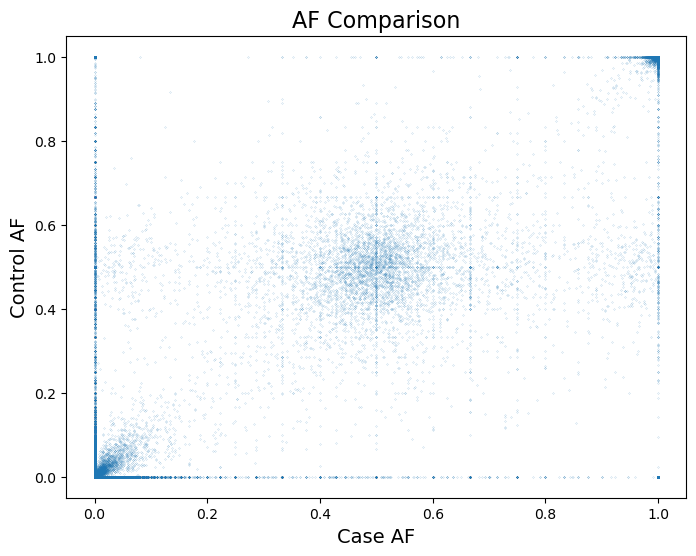

In [3]:
import gzip
import matplotlib.pyplot as plt

def get_mut_pos(chr,pos):
    if chr[:3] == "chr":
        chr_pos = f"{chr[3:]}:{pos}"
    else:
        chr_pos = f"{chr}:{pos}"
    return chr_pos

    
# 定义函数,从VCF文件中提取指定位置的AF值和REF/ALT信息
def extract_af_and_alleles(vcf_file, positions):
    afs = {}
    ref_alts = {}
    with gzip.open(vcf_file, "rt") if vcf_file.endswith(".gz") else open(vcf_file, "r") as f:
        for line in f:
            if not line.startswith("#"):
                fields = line.split()
                chr, pos, _, ref, alt = fields[:5]
                chr_pos = get_mut_pos(chr,pos)
                if chr_pos in positions:
                    info = fields[7]
                    for item in info.split(";"):
                        if item.startswith("AF="):
                            af = float(item[3:])
                            afs[chr_pos] = af
                            ref_alts[chr_pos] = (ref, alt)
                            break
    return afs, ref_alts

# 定义函数,统计REF/ALT相同的点的数量和占比
def calculate_same_ref_alt_stats(positions, case_ref_alts, ctrl_ref_alts, ref_alts):
    same_ref_alt_count = 0
    for pos in positions:
        case_ref, case_alt = case_ref_alts.get(pos, ("", ""))
        ctrl_ref, ctrl_alt = ctrl_ref_alts.get(pos, ("", ""))
        dbsnp_ref, dbsnp_alt = ref_alts.get(pos, ("", ""))
        if (case_ref, case_alt) == (dbsnp_ref, dbsnp_alt) or \
           (ctrl_ref, ctrl_alt) == (dbsnp_ref, dbsnp_alt) or \
           (case_ref, case_alt) == ("", "") and (ctrl_ref, ctrl_alt) == ("", ""):
            same_ref_alt_count += 1
    same_ref_alt_ratio = same_ref_alt_count / len(positions)
    return same_ref_alt_count, same_ref_alt_ratio

# 定义函数,绘制散点图
def plot_af_comparison(case_afs, ctrl_afs, positions):
    x,y = [],[]
    for pos in sorted(positions):
        case_af = case_afs.get(pos, 0)
        ctrl_af = ctrl_afs.get(pos, 0)
        x.append(case_af)
        y.append(ctrl_af)

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=0.01)
    plt.xlabel("Case AF", fontsize=14)
    plt.ylabel("Control AF", fontsize=14)
    plt.title("AF Comparison", fontsize=16)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.show()

# 主函数
def main(dbsnp_in_wes, case_vcf, ctrl_vcf):
    # 提取dbsnp_in_wes中的位置信息
    positions = set()
    with gzip.open(dbsnp_in_wes, "rt") if dbsnp_in_wes.endswith(".gz") else open(vcf_file, "r") as f:
        for line in f:
            if not line.startswith("#"):
                fields = line.split()
                chr, pos, _, ref, alt = fields[:5]
                positions.add(f"{chr}:{pos}")

    # 提取case_vcf和ctrl_vcf中的AF值和REF/ALT信息
    case_afs, case_ref_alts = extract_af_and_alleles(case_vcf, positions)
    #print(case_afs)
    
    ctrl_afs, ctrl_ref_alts = extract_af_and_alleles(ctrl_vcf, positions)
    #print(ctrl_afs)
    _, ref_alts = extract_af_and_alleles(dbsnp_in_wes, positions)


    # 统计REF/ALT相同的点的数量和占比
    same_ref_alt_count, same_ref_alt_ratio = calculate_same_ref_alt_stats(positions, case_ref_alts, ctrl_ref_alts, ref_alts)
    print(f"Number of positions with same REF/ALT: {same_ref_alt_count}")
    print(f"Ratio of positions with same REF/ALT: {same_ref_alt_ratio:.4f}")

    # 绘制散点图
    plot_af_comparison(case_afs, ctrl_afs, positions)

if __name__ == "__main__":
    dbsnp_in_wes = "/home/jovyan/work/00.database/14.dbSNP/All_20180418_in_WES.vcf.gz"
    case_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0009689008_CA/results/08.SvInDelSnvCalling/COAD_0009689008_CA.single_variant.snpeff.vcf"
    #case_vcf = ""
    #ctrl_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/0012934312_N/results/08.SvInDelSnvCalling/COAD_0012934312_N.single_variant.snpeff.vcf"
    ctrl_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0009689008_N/results/08.SvInDelSnvCalling/COAD_0009689008_N.single_variant.snpeff.vcf"
    main(dbsnp_in_wes, case_vcf, ctrl_vcf)

Number of positions with same REF/ALT: 10239108
Ratio of positions with same REF/ALT: 0.9983


KeyboardInterrupt: 

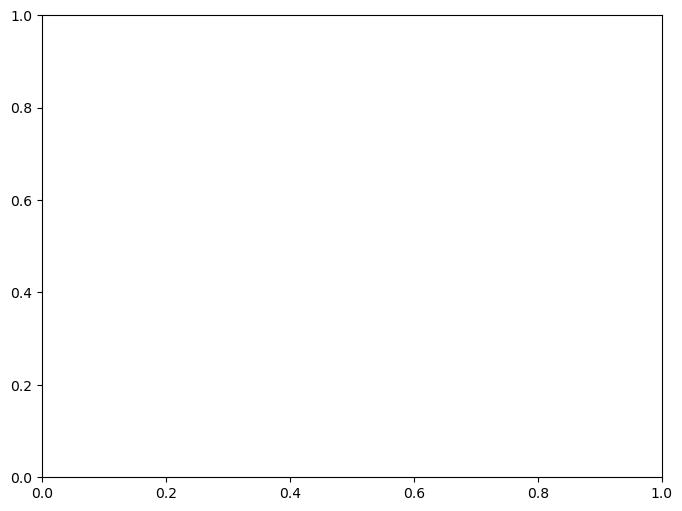

In [4]:
if __name__ == "__main__":
    dbsnp_in_wes = "/home/jovyan/work/00.database/14.dbSNP/All_20180418_in_WES.vcf.gz"
    case_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0012934312_CA/results/08.SvInDelSnvCalling/COAD_0012934312_CA.single_variant.snpeff.vcf"
    #case_vcf = ""
    ctrl_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0012934312_N/results/08.SvInDelSnvCalling/COAD_0012934312_N.single_variant.snpeff.vcf"
    #ctrl_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/0009689008_N/results/08.SvInDelSnvCalling/COAD_0009689008_N.single_variant.snpeff.vcf"
    main(dbsnp_in_wes, case_vcf, ctrl_vcf)

In [ ]:
if __name__ == "__main__":
    dbsnp_in_wes = "/home/jovyan/work/00.database/14.dbSNP/All_20180418_in_WES.vcf.gz"
    case_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0014215947_CA/results/08.SvInDelSnvCalling/COAD_0014215947_CA.single_variant.snpeff.vcf"
    #case_vcf = ""
    ctrl_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0014215947_N/results/08.SvInDelSnvCalling/COAD_0014215947_N.single_variant.snpeff.vcf"
    #ctrl_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/0009689008_N/results/08.SvInDelSnvCalling/COAD_0009689008_N.single_variant.snpeff.vcf"
    main(dbsnp_in_wes, case_vcf, ctrl_vcf)

In [ ]:
if __name__ == "__main__":
    dbsnp_in_wes = "/home/jovyan/work/00.database/14.dbSNP/All_20180418_in_WES.vcf.gz"
    case_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0014274065_CA/results/08.SvInDelSnvCalling/COAD_0014274065_CA.single_variant.snpeff.vcf"
    #case_vcf = ""
    ctrl_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/03.Result.SAKit2/0014274065_N/results/08.SvInDelSnvCalling/COAD_0014274065_N.single_variant.snpeff.vcf"
    #ctrl_vcf = "/home/jovyan/work/10.data_CODA_ahslyy/0009689008_N/results/08.SvInDelSnvCalling/COAD_0009689008_N.single_variant.snpeff.vcf"
    main(dbsnp_in_wes, case_vcf, ctrl_vcf)

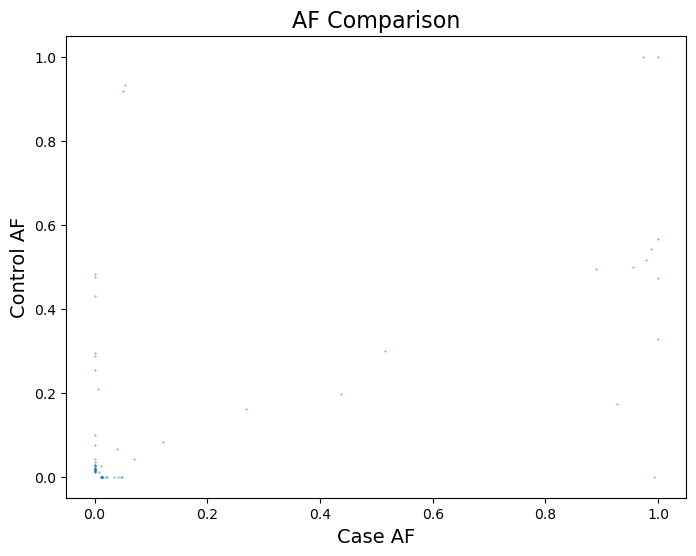

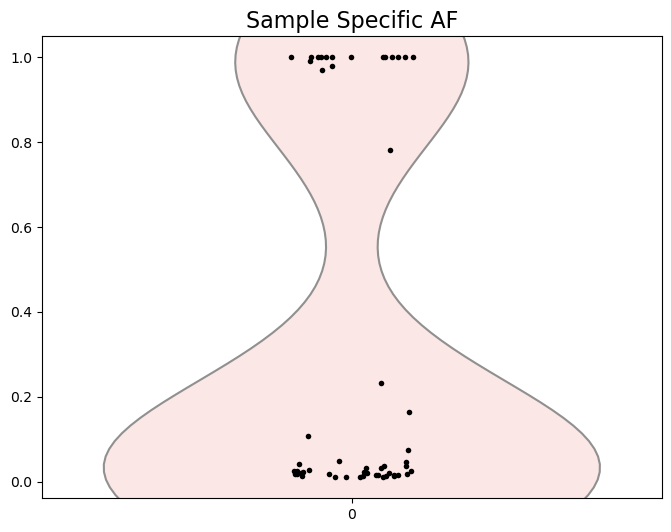

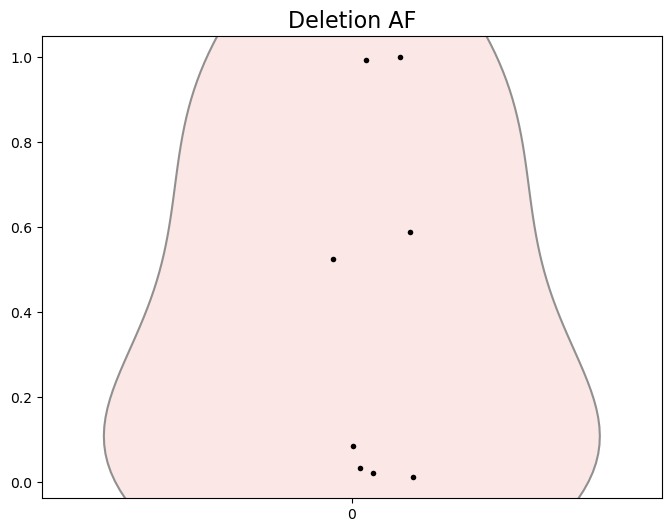

In [5]:
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

def get_mut_pos(chr, pos):
    if chr[:3] == "chr":
        chr_pos = f"{chr[3:]}:{pos}"
    else:
        chr_pos = f"{chr}:{pos}"
    return chr_pos

def extract_af_and_alleles(vcf_file, dbsnp_positions):
    afs = {}
    ref_alts = {}
    sample_specific_afs = []
    deletion_afs = []
    with gzip.open(vcf_file, "rt") if vcf_file.endswith(".gz") else open(vcf_file, "r") as f:
        for line in f:
            if not line.startswith("#"):
                fields = line.split()
                chr, pos, _, ref, alt = fields[:5]
                chr_pos = get_mut_pos(chr, pos)
                if  chr_pos in dbsnp_positions:
                    info = fields[7]
                    case_dp,case_af = int(fields[9].split(":")[1]), float(fields[9].split(":")[6])
                    ctrl_dp,ctrl_af = int(fields[10].split(":")[1]), float(fields[10].split(":")[6])
                    status = [item.split("=")[1] for item in info.split(";") if item.startswith("STATUS=")]
                    if "SampleSpecific" in status:
                        if case_dp >= 20:
                            sample_specific_afs.append(case_af)
                    elif "Deletion" in status:
                        if ctrl_dp >= 20:
                            deletion_afs.append(ctrl_af)
                    else:
                        if case_dp >= 20 and ctrl_dp >= 20:
                            afs[chr_pos] = (case_af, ctrl_af)
                            ref_alts[chr_pos] = (ref, alt)
                        
    return afs, ref_alts, sample_specific_afs, deletion_afs

def load_dbsnp_positions(dbsnp_in_wes):
    dbsnp_positions = set()
    with gzip.open(dbsnp_in_wes, "rt") if dbsnp_in_wes.endswith(".gz") else open(dbsnp_in_wes, "r") as f:
        for line in f:
            if not line.startswith("#"):
                fields = line.split()
                chr, pos, _, ref, alt = fields[:5]
                chr_pos = get_mut_pos(chr, pos)
                dbsnp_positions.add(chr_pos)
    return dbsnp_positions

def plot_violin_and_strip(data, title, color):
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data, inner=None, color=color, alpha=0.5)
    sns.stripplot(data=data, color='black', jitter=True, size=4)
    plt.title(title, fontsize=16)
    plt.show()
    
def main(vcf_file, dbsnp_in_wes):
    '''
    positions = set()
    with gzip.open(vcf_file, "rt") if vcf_file.endswith(".gz") else open(vcf_file, "r") as f:
        for line in f:
            if not line.startswith("#"):
                fields = line.split()
                chr, pos, _, ref, alt = fields[:5]
                chr_pos = get_mut_pos(chr, pos)
                positions.add(chr_pos)
    '''
    dbsnp_positions = load_dbsnp_positions(dbsnp_in_wes)

    afs, ref_alts, sample_specific_afs, deletion_afs = extract_af_and_alleles(vcf_file, dbsnp_positions)

    case_afs = [af[0] for af in afs.values()]
    ctrl_afs = [af[1] for af in afs.values()]

    plot_af_comparison(case_afs, ctrl_afs)

    plot_violin_and_strip(sample_specific_afs, "Sample Specific AF", "mistyrose")
    plot_violin_and_strip(deletion_afs, "Deletion AF", "mistyrose")
    
def plot_af_comparison(case_afs, ctrl_afs):
    plt.figure(figsize=(8, 6))
    plt.scatter(case_afs, ctrl_afs, s=0.1)
    plt.xlabel("Case AF", fontsize=14)
    plt.ylabel("Control AF", fontsize=14)
    plt.title("AF Comparison", fontsize=16)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.show()
    

if __name__ == "__main__":
    dbsnp_in_wes = "/home/jovyan/work/00.database/14.dbSNP/All_20180418_in_WES.vcf.gz"
    vcf_file = "/home/jovyan/work/10.data_CODA_ahslyy/05.SNVINDEL/COAD_0009689008_vs_0012934312.single_variant.vcf"
    main(vcf_file, dbsnp_in_wes)

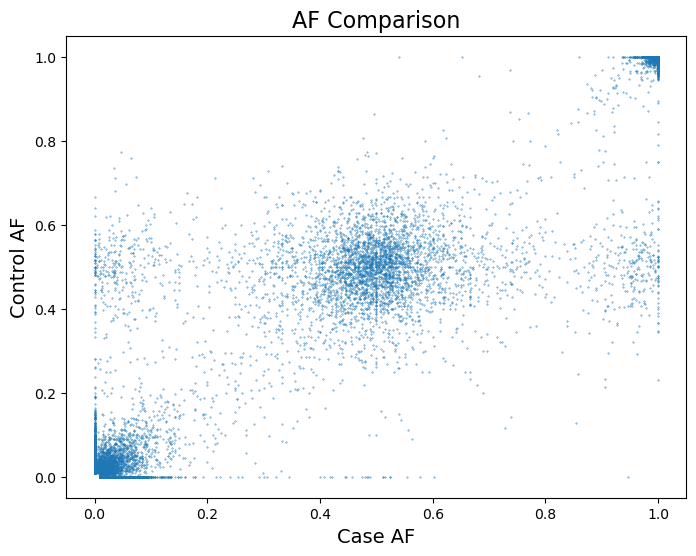

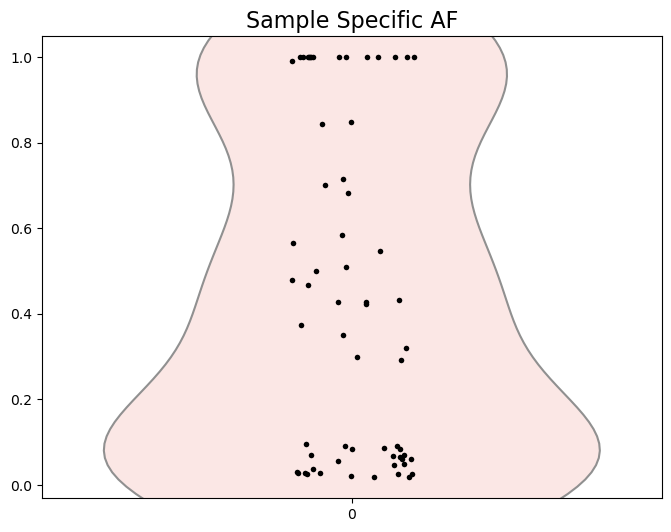

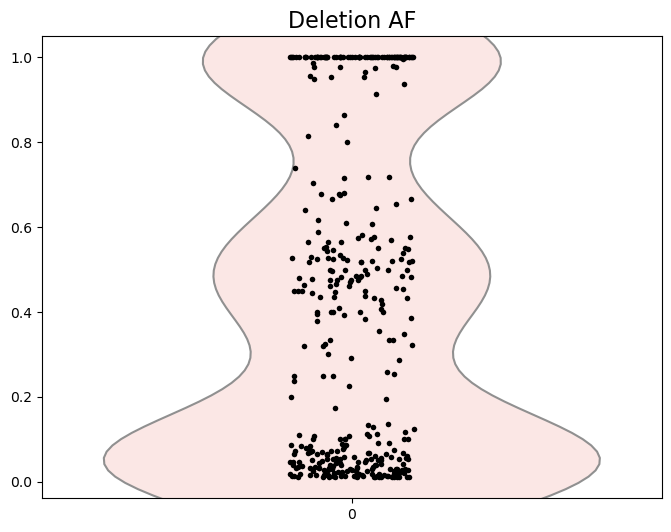

In [6]:
if __name__ == "__main__":
    dbsnp_in_wes = "/home/jovyan/work/00.database/14.dbSNP/All_20180418_in_WES.vcf.gz"
    vcf_file = "/home/jovyan/work/10.data_CODA_ahslyy/05.SNVINDEL/COAD_0009689008.single_variant.vcf"
    main(vcf_file, dbsnp_in_wes)

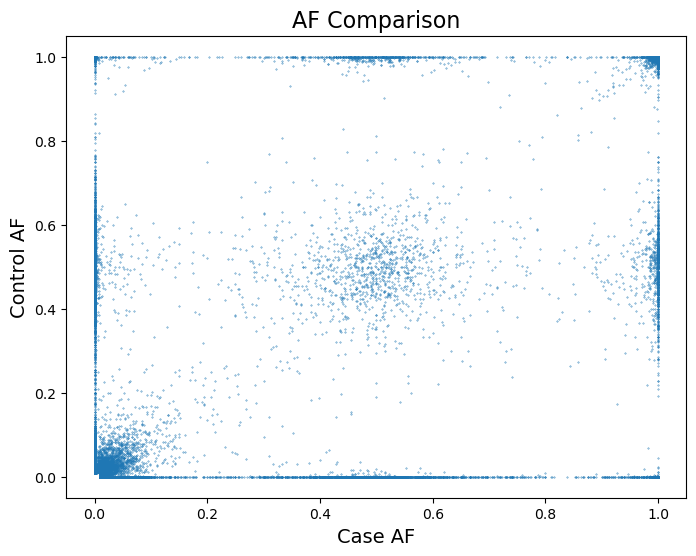

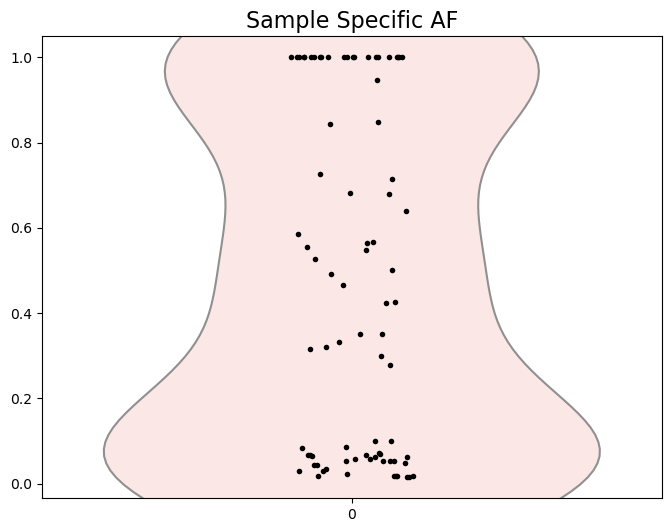

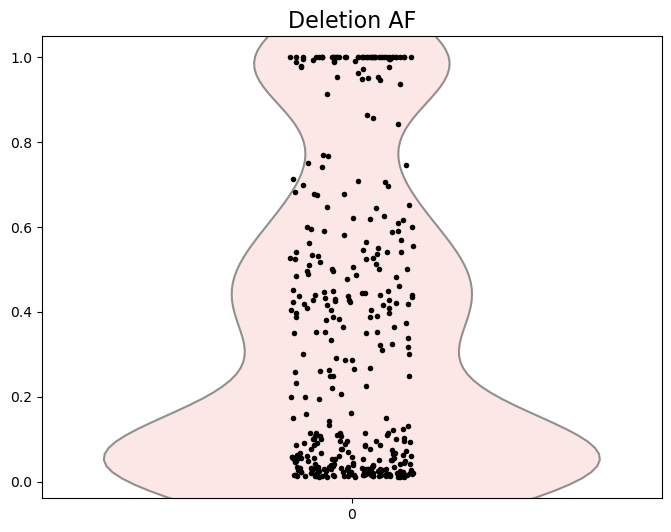

In [7]:
if __name__ == "__main__":
    dbsnp_in_wes = "/home/jovyan/work/00.database/14.dbSNP/All_20180418_in_WES.vcf.gz"
    vcf_file = "/home/jovyan/work/10.data_CODA_ahslyy/05.SNVINDEL/COAD_0009689008_vs_0012934312_all.single_variant.snpeff.vcf"
    main(vcf_file, dbsnp_in_wes)